<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-definitions" data-toc-modified-id="Imports-and-definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and definitions</a></span></li><li><span><a href="#Load-tables" data-toc-modified-id="Load-tables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load tables</a></span></li><li><span><a href="#Sentiment-analysis" data-toc-modified-id="Sentiment-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sentiment analysis</a></span><ul class="toc-item"><li><span><a href="#Calculate-sentiments-for-all-tweets" data-toc-modified-id="Calculate-sentiments-for-all-tweets-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Calculate sentiments for all tweets</a></span></li><li><span><a href="#Average-sentiment-of-tweets-by-user" data-toc-modified-id="Average-sentiment-of-tweets-by-user-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Average sentiment of tweets by user</a></span></li><li><span><a href="#Sentiments-over-time-for-all-tweets" data-toc-modified-id="Sentiments-over-time-for-all-tweets-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Sentiments over time for all tweets</a></span></li></ul></li></ul></div>

# Analysis 2 - Sentiment

## Imports and definitions

In [1]:
%load_ext memory_profiler

In [2]:
import warnings
import datetime as dt
import re
from collections import Counter
import numpy as np
import statsmodels.api as sm
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('fivethirtyeight') #Generally nice
from pandasql import sqldf
sql = lambda x: sqldf(x, globals())
from textblob import TextBlob
path = 'output_data/'

## Load tables

In [3]:
tweet = pd.read_parquet(path+'cleantweets.parquet')

In [4]:
user = pd.read_csv(path+'user.csv')
#hashtag = pd.read_csv(path+'hashtag.csv')
#mention = pd.read_csv(path+'mention.csv')
#tweet_hashtag = pd.read_csv(path+'tweet_hashtag.csv')
#tweet_mention = pd.read_csv(path+'tweet_mention.csv')

## Sentiment analysis

### Calculate sentiments for all tweets

In [5]:
%%time
# Sentiments come from sentences so drop the word list
unwanted=['words']
columns = [column for column in tweet.columns if column not in unwanted]
tweet = tweet[columns]
#tweet.set_index('id', inplace=True)
tweet['sentiment']=tweet['text'].apply(lambda x: TextBlob(x).sentiment[0])

CPU times: user 2min 38s, sys: 149 ms, total: 2min 38s
Wall time: 2min 39s


In [6]:
user.head()

,created_at,description,followers_count,friends_count,name,screen_name,total_tweets
0,2014-11-30,"Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed ""-BW"" come directly from Governor.",5870,550,Governor Bill Walker,AkGovBillWalker,1642
1,2009-04-20,"U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement",170717,91751,Amy Klobuchar,amyklobuchar,5567
2,2013-04-24,"Congressman for Maryland's 4th Congressional District, former Army Aviator, father and husband",6067,369,Anthony G. Brown,AnthonyBrownMD4,1878
3,2011-03-21,"Husband of 43 yrs, Dad of 4, Papaw of 6. Lifelong Arkansan. Governor of Arkansas. Former Congressman, Admin. of DEA, Under Sec. of Homeland Security.",25747,598,Gov. Asa Hutchinson,AsaHutchinson,3778
4,2011-01-06,I am proud to represent the 8th Congressional District of Georgia.,13048,313,Rep. Austin Scott,AustinScottGA08,2022


### Average sentiment of tweets by user

In [7]:
%%time
query = f'''
SELECT
    u.created_at,
    u.description,
    u.followers_count,
    u.friends_count,
    u.name,
    u.screen_name,
    u.total_tweets,
    avg_sentiment.average_sentiment
FROM user AS u
INNER JOIN
    (SELECT
        screen_name,
        AVG(sentiment) AS average_sentiment
    FROM
        tweet
    GROUP BY
        screen_name
    ORDER BY
        AVG(sentiment)
    ) AS avg_sentiment
ON u.screen_name = avg_sentiment.screen_name
'''
user_sent = sql(query)
user_sent.head(2)

CPU times: user 10.1 s, sys: 487 ms, total: 10.6 s
Wall time: 10.6 s


,created_at,description,followers_count,friends_count,name,screen_name,total_tweets,average_sentiment
0,2014-11-30,"Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed ""-BW"" come directly from Governor.",5870,550,Governor Bill Walker,AkGovBillWalker,1642,0.18
1,2009-04-20,"U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement",170717,91751,Amy Klobuchar,amyklobuchar,5567,0.24


In [8]:
y = user_sent.followers_count.values
x = user_sent.friends_count.values
x = sm.add_constant(x)
model = sm.OLS(y, x, hasconst=True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8677
Date:                Thu, 15 Oct 2020   Prob (F-statistic):              0.352
Time:                        16:02:02   Log-Likelihood:                -8558.6
No. Observations:                 545   AIC:                         1.712e+04
Df Residuals:                     543   BIC:                         1.713e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.435e+05   7.22e+04      1.989      0.047    1808.461    2.85e+05
x1            10.1649     10.912      0.932      0.352     -11.270      31.600
==============================================================================
Omnibus:                     1182.262   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2182683.987
Skew:                          16.990   Prob(JB):                         0.00
Kurtosis:                     311.162   Cond. No.                     6.95e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is no correlation between any of friends_count, followers_count, total_tweets and avg_sentiment.

In [9]:
tweet.head(2)

,created_at,retweet_count,screen_name,text,wordtext,sentiment
id,,,,,,
877418565,2008-08-04 17:28:51,0,JohnBoozman,conference call about weekend trip iraq visit arkansas troops,conference call weekend trip iraq visit arkansas troops,0.00
879695803,2008-08-06 20:35:36,0,JohnBoozman,being interviewed by karn his arkansas world trade center trip,interviewed karn arkansas world trade center trip,-0.10


### Sentiments over time for all tweets

In [10]:
def get_monthly_sentiment(start_year=2016, end_year=2016):
    query = f'''
        SELECT SUBSTR(
                   DATE(t.created_at,'start of month'),
                   1,7) AS month,
                AVG(t.sentiment) AS avg_sentiment
        FROM tweet AS t
        WHERE CAST(STRFTIME('%Y',t.created_at) AS INT) >= {start_year}
                AND
              CAST(STRFTIME('%Y',t.created_at) AS INT) <= {end_year}
        GROUP BY month
        ORDER BY month
        ;'''
    return sql(query)

In [11]:
df = get_monthly_sentiment(2008, 2017)

I could use a window function in SQL but...

In [12]:
df['ma'] = df.rolling(window=6)['avg_sentiment'].mean()

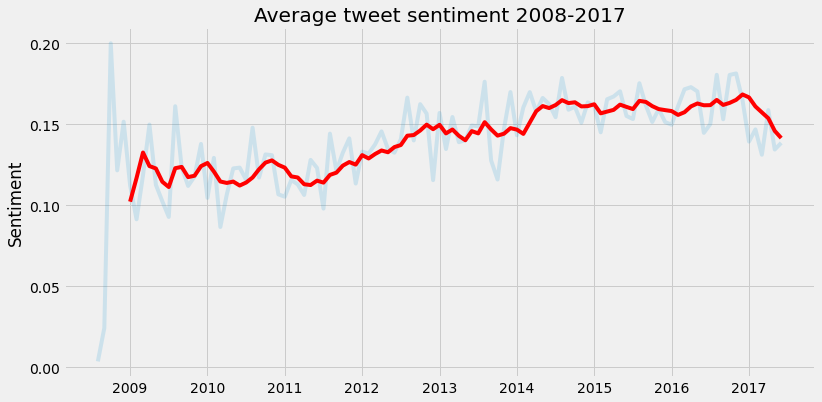

In [13]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
plt.title('Average tweet sentiment 2008-2017')
plt.xticks(range(5,102,12),range(2009,2018))
plt.yticks(np.arange(0,0.21,0.05))
plt.ylabel('Sentiment')
ax.plot(df.month, df.avg_sentiment, alpha=0.15)
ax.plot(df.month, df.ma, color='r')
plt.show()